# Google Trends analytics using Python
- Here we will be analyzing the Google search trends on the queries of our intered {You will get a chance to provide input}.

In [259]:
# import necessary libaries
import pandas as pd
from pytrends.request import TrendReq
import matplotlib.pyplot as plt

import numpy as np

# Connect to Google
- The first step after installation is to connect Pytrends to Google Trends so that WE can send a request and get the information WE need.

In [260]:
# The TrendReq receives two important parameters; hl & tz.
# hl stands for hosting language for accessing Google Trends; in this example, we set English.
# tz stands for timezone
trends = TrendReq(hl='en-US', tz= 360, timeout=(10,25))    

# Build Payload
- The build_payload method from Pytrends is used to build a list of keywords that want to search in Google Trends. Can also specify the timeframe to gather data and the category to query the data from.

In [261]:
kw_list = input("Enter the word that wanna see in Google Trends. >> ").split(" ")  # list of keywords to get data 
kw_list

Enter the word that wanna see in Google Trends. >> Health


['Health']

In [262]:
# kw_list: list of the target search terms 
# cat: Category to narrow result fx. Art, Entertainment
# timeframe: Date to start from fx. Defaults to last 5yrs is 'today 5-y' or Everything is 'all'
# geo: Location of interest represent by two letter country abbreviation fx. United States is 'US' or Defaults to World
# gprop: What Google property to filter to fx. "image" or "news" default to web searches

trends.build_payload(kw_list, cat=0, timeframe='today 1-m', geo= '', gprop='') 

In [263]:
# lets check if we got the data from google or not?
trends

# What kind of data want to pull? possible methods are:
- Interest Over Time: returns historical, indexed data for when the keyword was searched
- Historical Hourly Interest:  returns historical, indexed, hourly data for when the keyword was searched
- Interest by Region: returns data for where the keyword is most searched
- Related Topics: returns data for the related keywords to a provided keyword
- Related Queries: returns data for the related keywords to a provided keyword
- Trending Searches: returns data for latest trending searches
- Top Charts: returns the data for a given topic
- Suggestions: returns a list of additional suggested keywords that can be used to refine a trend search.

In [264]:
# Function to Disply in the figure
def displayfig(x, y, title, x_label, y_label, fsize):
    """ The function will take x & value including title, x_label & y_label, & figuresize then display the figure"""
    plt.figure(figsize= fsize)
    plt.plot(x,y)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

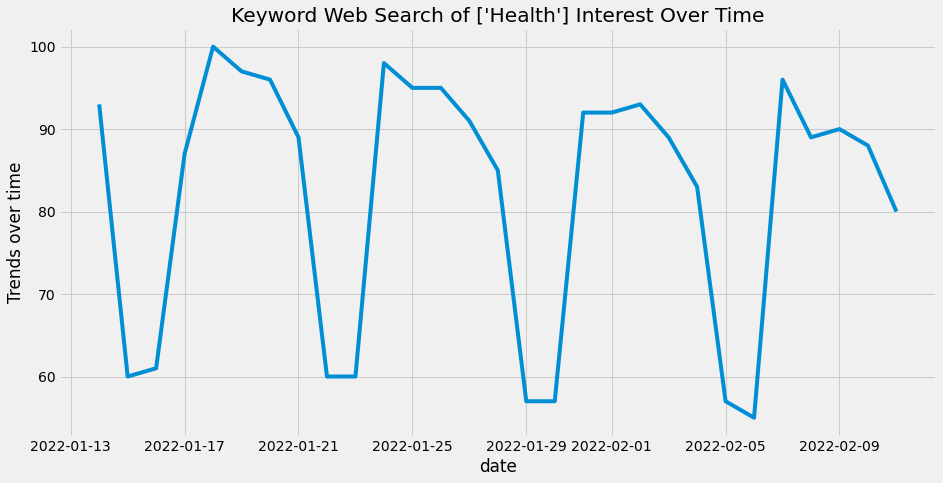

In [265]:
# Interest Over Time
data_over_time= trends.interest_over_time()
data_over_time = data_over_time.reset_index()

# Disply in the figure
displayfig(x=data_over_time["date"], y=data_over_time.iloc[:, 1], title= "Keyword Web Search of {kw_list} Interest Over Time".format(kw_list=kw_list), x_label= "date", y_label="Trends over time", fsize= (14, 7))

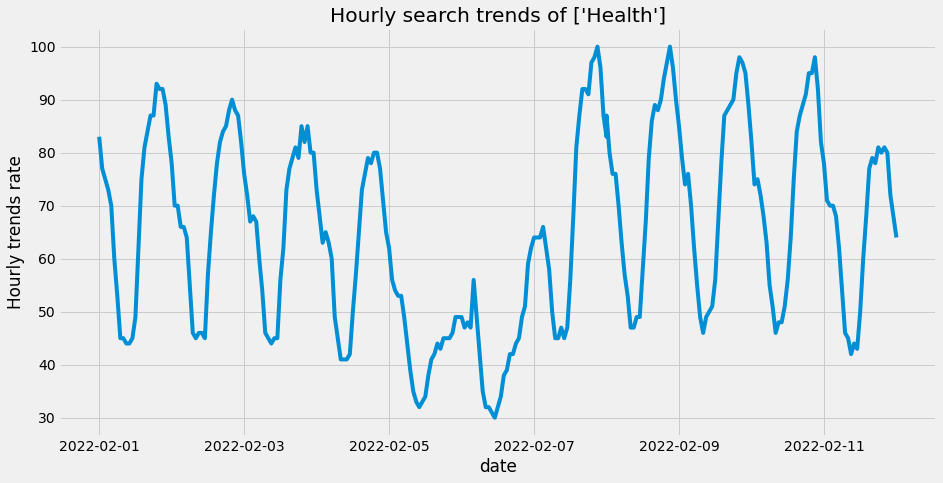

In [266]:
# Historical Hourly Interest (The hourly interest of the keyword)
hourly_trends= trends.get_historical_interest(kw_list, year_start=2022, month_start=2, day_start=1, hour_start=0, year_end=2022, month_end=2, day_end=12, hour_end=0)
hourly_trends = hourly_trends.reset_index()

# Disply in the figure
plt.figure(figsize= (14, 7))
plt.plot(hourly_trends["date"], hourly_trends.iloc[:, 1])
plt.title("Hourly search trends of {kw_list}".format(kw_list=kw_list))
plt.xlabel("date")
plt.ylabel("Hourly trends rate")
plt.show()

In [267]:
# Interest by Region (To show you which countries search the keyword on a scale of 0 to 100, where 100 represents a country with the most search)
trends_by_region= trends.interest_by_region(resolution='DENMARK', inc_low_vol=True, inc_geo_code=False)
trends_by_region = trends_by_region.sort_values(by=kw_list, ascending=False)
print(trends_by_region.head(10))

               Health
geoName              
New Zealand       100
Palau              83
Australia          78
Eritrea            73
Zambia             72
Malawi             64
Canada             58
Botswana           57
United States      55
Guam               54


In [268]:
# Related Queries (keywords that are closely tied to a primary keyword of the choice)
related_queries= trends.related_queries()
related_queries[kw_list[0]]['top'].head(10)

,query,value
0,mental health,100
1,health care,84
2,health insurance,67
3,what is health,48
4,health department,38
5,my health,36
6,public health,31
7,good health,23
8,one health,17
9,health card,17


In [272]:
# Trending topics of the year
df= pd.DataFrame()

for year in range(2004, 2022):
    trending = trends.top_charts(year, hl= "en-US", geo= "GLOBAL")
    df[year]= trending.title
    
print(df.head())

             2004                  2005             2006  \
0         Ferrari                  iPod   Aaron Spelling   
1             BMW        Digital Camera    Kirby Puckett   
2     Lamborghini            MP3 Player        Jack Wild   
3  Nissan Skyline             iPod Mini  Clifford Geertz   
4         Porsche  PlayStation Portable     Muriel Spark   

                     2007               2008              2009        2010  \
0           American Idol    Joe The Plumber   Michael Jackson        iPad   
1                 YouTube    Jeremiah Wright      Transformers    iPhone 4   
2          Britney Spears           Maverick            Eminem  Nokia 5530   
3  2007 Cricket World Cup      William Ayers  Naruto Shippuden  HTC EVO 4g   
4            Chris Benoit  Bridge To Nowhere           Beyoncé  Nokia N900   

                 2011                2012             2013  \
0  Amazon Kindle Fire  Southwest Airlines  Oscar Pistorius   
1           iPhone 4s     United Airlines  Aar